# Research Notebook: Running test cases on CFMiso to probe its abilities and limits


Here we will curate some initial surface conditions, and test the limits of the firn depth for this model.
The primary tests here will be around the Tskin. 
1. ability to simulate step changes, 
2. ability to simulate seasonal cycles, 
3. limits of firn depth in these simulations.
4. test limits and format of time resolution

These simulations will be run with a bdot = 0.

Input/output will be saved the ./CommunityFirnModel/data folder 

Start this notebook from the ./CommunityFirnModel repo directory on your computer 

## To Do, 6 April 2024

1. plot the final density profiles with meaningful line styles
2. plot the density and temperature time series as depth/time contour plots
3. iterate scenarios with different accumulation rates, make sure the accumulation rates are the same between each scenario 



In [1]:
import sys 

## run from notebooks folder
homePath= './CFM_main/'
inputDataPath = '../data/input/'
outputDataPath = '../data/output/'

sys.path.append(homePath)

### Import necessary libraries

In [2]:
# import statsmodels.api as sm
import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import netCDF4 as nc
import sys
import os
import pickle 
import seaborn as sns 
import glob
from datetime import datetime, timedelta, date
import time
import json
import shutil
import xarray as xr
import copy
import pprint

SPY = 365.25*24*3600

from firn_density_nospin import FirnDensityNoSpin
from siteClimate_from_RCM import getClimate #get data from RCM
from RCMpkl_to_spin import makeSpinFiles

### Set plot parameters (seaborn, matplotlib)

In [3]:
sb=True
if sb:
    sns.set()
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
#     sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid",{"xtick.top":True, "xtick.bottom":True,"ytick.left":True, "ytick.right":True})
# plt.style.use('seaborn-notebook')

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams.update({'figure.autolayout': True})
fontsz = 20

### Curate/create, save, and then upload the input data for these tests. 

In [4]:

# make temperature time series for sinusoidal tests in pandas format at minute resolution, hourly resolution, daily resolution, monthly resolution.

# add different levels of noise at the time scales (e.g. 0.1 K, 1 k, 2 k, 4 k)

cycles = 10 # how many sine cycles
resolution = 365*24*60*10 # how many datapoints to generate

length = np.pi * 2 * cycles

DTseas = 20 # size of seasonal cycle, K
Tannual = 243 # mean annual temperature, K

Tseasonal = DTseas*np.sin(np.arange(0, length, length / resolution))+Tannual
numDays = np.arange(1,len(Tseasonal)+1)




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87600 entries, 2000-01-01 00:00:00 to 2009-12-28 23:00:00
Freq: h
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Tseas0noise    87600 non-null  float64
 1   Tseas0.1noise  87600 non-null  float64
 2   Tseas1noise    87600 non-null  float64
 3   Tseas2noise    87600 non-null  float64
 4   Tseas4noise    87600 non-null  float64
 5   Tseas10noise   87600 non-null  float64
dtypes: float64(6)
memory usage: 4.7 MB


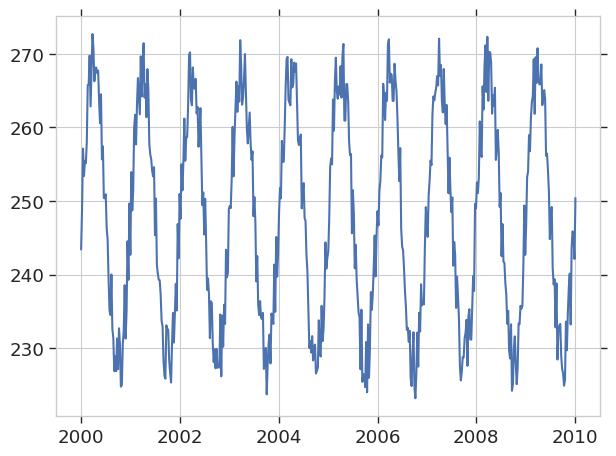

In [5]:

inputDF_min = pd.DataFrame(index = pd.DatetimeIndex(pd.period_range(start = '2000-01-01',periods=resolution,freq='min').to_timestamp()), columns = ['Tseas0noise'])
inputDF_min.Tseas0noise= Tseasonal


inputDF_hour = inputDF_min.resample('h').mean()
inputDF_day = inputDF_min.resample('D').mean()
inputDF_week = inputDF_min.resample('W').mean()
inputDF_month = inputDF_min.resample('MS').mean()

# create random noise for the model tests
lenMin = len(inputDF_min.index)
lenHour = len(inputDF_hour.index)
lenDaily = len(inputDF_day.index)
lenWeek = len(inputDF_week.index)
lenMonth = len(inputDF_month.index)

listLevels = [0.1,1,2,4,10] # noise levels in K

for l in listLevels:
    inputDF_min['Tseas'+str(l)+'noise'] = inputDF_min.Tseas0noise + np.random.rand(lenMin)*l
    inputDF_hour['Tseas'+str(l)+'noise'] = inputDF_hour.Tseas0noise + np.random.rand(lenHour)*l
    inputDF_day['Tseas'+str(l)+'noise'] = inputDF_day.Tseas0noise + np.random.rand(lenDaily)*l
    inputDF_week['Tseas'+str(l)+'noise'] = inputDF_week.Tseas0noise + np.random.rand(lenWeek)*l
    inputDF_month['Tseas'+str(l)+'noise'] = inputDF_month.Tseas0noise + np.random.rand(lenMonth)*l
    

# make initial temperature profile (no spin up) for step-change tests, make step change temperature time series of 
# different magnitudes (0.1 K, 1 K, 2 K, 10 K). Use the same array of time resolution.

inputDF_min.head()

plt.figure
plt.plot(inputDF_week.index,inputDF_week.Tseas10noise)

inputDF_hour.info()


In [6]:
# fill in the rest of the DFs for evaporation, melt, total precip, snow precip, everything is zero at this point for these parameters

massParamsList = ['EVAP','SMELT','PRECTOT','PRECSNO']

for m in massParamsList:
    if (m == 'EVAP') | (m == 'SMELT'):
        inputDF_min[m]=0;
        inputDF_hour[m]=0;
        inputDF_day[m]=0;
        inputDF_week[m]=0;
        inputDF_month[m]=0;
    else:
        inputDF_min[m]=1000/365/24/60;
        inputDF_hour[m]=1000/365/24;
        inputDF_day[m]=1000/365;
        inputDF_week[m]=1000/52;
        inputDF_month[m]=1000/12;
        
inputDF_week.to_csv(inputDataPath+'modelTest_1wk_res.csv')
inputDF_week.to_pickle(inputDataPath+'modelTest_1wk_res.pkl')
inputDF_month.to_csv(inputDataPath+'modelTest_1mon_res.csv')
inputDF_week.to_pickle(inputDataPath+'modelTest_1mon_res.pkl')

In [26]:
# create dictionary of dataframes for this series of tests

listRes = ['1W','1M']   # what is the abbreviation for, probably the resample abbreviations
noiseDict = dict(zip(['0','0.1','1','2','4','10'],['Tseas0noise','Tseas0.1noise','Tseas1noise','Tseas2noise','Tseas4noise','Tseas10noise']))
dfExpDict = dict(zip(listRes,[inputDF_week, inputDF_month]))




### Set CFM configuration

In [27]:


### NOTE: 22 March 2024 -- get this json file to be more reactive to the input parameters and file names generated below

### This function contains all of the CFM configuration options.
### The values here are more or less the defaults.
### You can change them here if you want to change default settings,
### but if you want to change on a run-by-run basis I recommend doing so in the cell below.

# doublegrid to True - turning on double grid routine (for faster running of things, allowing thicker firn column without much higher run times).

def makejson(ipd,opd):
    false = False
    true = True
    c = {
    "InputFileFolder": ipd,
    "InputFileNameTemp": "tskin.csv",
    "InputFileNamebdot": "smb.csv",
    "InputFileNameIso": "isotope.csv",
    "InputFileNamerho": "rhos.csv",
    "InputFileNamemelt": "melt.csv",
    "resultsFolder": opd,
    "initfirnFile": "firndata.csv",
    "initprofile": false,
    "input_type": "dataframe",
    "input_type_options": ["csv","dataframe"],
    "DFresample": "1D",
    "DFfile": "inputData.pkl",
    "physRho": "GSFC2020",
    "physRho_options":["HLdynamic","HLSigfus","Li2004","Li2011","Helsen2008","Arthern2010S","Arthern2010T","Li2015","Goujon2003","Barnola1991","Morris2014","KuipersMunneke2015","Crocus","Ligtenberg2011"],
    "MELT": false,
    "ReehCorrectedT": false,
    "FirnAir": false,
    "AirConfigName": "AirConfig.json",
    "TWriteInt": 1,
    "TWriteStart": 1980.0,
    "int_type": "nearest",
    "int_type_options": ["nearest","linear"],
    "SeasonalTcycle": false,
    "SeasonalThemi": "north",
    "coreless": true,
    "TAmp":10.0,
    "physGrain": false,
    "calcGrainSize": false,
    "GrGrowPhysics": "Arthern",
    "GrGrowPhysics_options": ["Arthern", "Katsushima"],
    "heatDiff": true,
    "conductivity": "Calonne2019",
    "conductivity_options": ["Schwander","Yen_fixed","Yen_var","Anderson","Yen_b","Sturm","VanDusen","Schwerdtfeger","Riche","Jiawen","mix","Calonne2011","Calonne2019"],
    "variable_srho": false,
    "srho_type": "userinput",
    "srho_type_options": ["userinput","param","noise"],
    "rhos0": 350.0,
    "r2s0": 1.0e-8,
    "AutoSpinUpTime": false,
    "yearSpin": 20,
    "H": 3000,
    "HbaseSpin": 2880.0,
    "stpsPerYear": 12.0,
    "D_surf": 1.0,
    "bdot_type": "mean",
    "bdot_type_options": ["instant","mean","stress"],
    "grid_outputs": false,
    "grid_output_res": 0.25,
    "isoDiff": true,
    "iso": ["d18O","dD"],
    "isoOptions":["d18O","dD","NoDiffusion"],
    "spacewriteint": 1,
    "strain": false,
    "du_dx": 1e-5,
    "outputs": ["density", "depth", "temperature", "age", "DIP","isotopes"],
    "outputs_options": ["density", "depth", "temperature", "age", "Dcon", "bdot_mean", "climate", "compaction", "grainsize", "temp_Hx", "isotopes", "BCO", "DIPc", "DIP", "LWC","gasses", "PLWC_mem", "viscosity", "runoff",
    "refrozen"],
    "resultsFileName": 'tempResults.hdf5',
    "spinFileName": 'tempSpin.hdf5',
    "doublegrid": true,
    "nodestocombine": 30,
    "multnodestocombine": 12,
    "Dnodestocombine": 30,
    "Dmultnodestocombine": 12,
    "grid1bottom": 5.0,
    "grid2bottom": 10.0,
    "spinup_climate_type": "mean",
    "spinup_climate_type_options": ["mean", "initial"],
    "manual_climate": false,
    "deepT": 255.88,
    "bdot_long": 0.49073,
    "manual_iceout": false,
    "iceout": 0.23,
    "QMorris": 110.0e3,
    "timesetup": "exact",
    "timesetup_options": ["exact","interp","retmip"],
    "liquid": "bucket",
    "liquid_options": ["percolation_bucket","bucketVV","resingledomain","prefsnowpack"],
    "merging": false,
    "merge_min": 1e-4,
    "LWCcorrect": false,
    "manualT": false,
    "no_densification": false,
    "rad_pen": false,
    "site_pressure": 1013.25,
    "output_bits": "float32",
    "spinUpdate": true,
    "spinUpdateDate": 1980.0,
    "DIPhorizon": 100.0,
    "NewSpin": true,
    "ColeouLesaffre": false,
    "IrrVal": 0.02,
    "RhoImp": 830.0,
    "DownToIce": false,
    "ThickImp": 0.1,
    "Ponding": false,
    "DirectRunoff": 0.0,
    "RunoffZuoOerlemans": false,
    "Slope": 0.1,
    "SUBLIM": True
    }

    return c

### Info on how CFM runs

The CFM itself (i.e, firn_density_nospin.py) takes inputs as vectors of temperature, accumulation, etc., and decimal time. 
The following line calls a script that takes the df_daily and creates a python dictionary (called Cd, for climate dictionary)
containing the vectors that the CFM needs to run. (converts the data from df_daily into these vectors)
the function also returns some other variables that will be used to configure the CFM run. (but are not important for what you are doing, generally speaking)

so, if you want to create your own forcing data you can either create a dataframe with a datetime index, which gets turned into the dictionary in the below function call,
or you could just create a dictionary with the needed keys (['time', 'TSKIN', 'BDOT', 'd18O', 'dD']), where 'time' is decimal date
we can't use pandas exclusively with datetime indicies because the datetime64 format has limitations


#### Configure the CFM run.
the variable 'c' is a dictionary with key-value pairs
if you want to alter anything in the config file I recommend doing so here.
note that not all CFM features will work with isotopes turned on - let me know if I need to change anything for you in that regard.



In [28]:
# try to run with spin files, the spin files need to have the same time resolution as the no spin files. 
# save the spin files and move to another location. Then move and load the spin files for the next time you need them

# next step - tyr to create a series of init profiles, then run with no spin. 




for res in listRes:

    timeres = res # set the time resolution for the model run. '5D' is 5 days, '1M' is one month, etc

    for n in noiseDict:

        print('***********************************************')
        print('running ' + res + ' resolution with ' + n + ' noise.')
        
        inputDF = dfExpDict[res].copy()
        inputDF = inputDF.loc[:,[noiseDict[n]]+massParamsList]
        inputDF = inputDF.rename(columns = {noiseDict[n]: 'TSKIN'})
        inputDF.to_pickle(inputDataPath+'inputDF.pkl')
        

        Cd, StpsPerYr, depth_S1, depth_S2, grid_bottom = makeSpinFiles(inputDF, timeres=timeres, Tinterp='mean', spin_date_st = 1990, spin_date_end = 2000, desired_depth=20)

        # set bottom density to be 700-800 kg/m3, rho_bottom = ?,then maybe don't set desired depth
        # or set desired_depth to a small depth. 

        # lower boundary condition is currently zero gradient, so maybe 
        # will not get longer run times for deeper snow, necessarily
        # set up sub-grid routine in json 

        # OK, this is wrong, but we will operate with it. This will have to be a different part of 'makeSpinFiles'
        Cd['d18O'] = 0.62* Cd['TSKIN'] - 15.25 #Johnsen 1989 eq. 2
        Cd['dD'] = 8.0 * Cd['d18O'] + 10 #Johnsen 1989 eq. 1

        runid=-9999

        #######
        ### Prepare config .json (which is a dictionary called c within this python script) ###
        ### edit as you wish here (the makejson function above just has defaults, you can change there as well)
        c = makejson(inputDataPath,outputDataPath)
        c['physRho'] = 'KuipersMunneke2015' # try with 'GSFC2020' and 'KuipersMunneke2015'
        c['runID'] = runid
        c['DFresample'] = timeres # resolution of the model run, e.g. '1d' is 1 day.
        c["doublegrid"] = False
        c['nodestocombine'] = 6 
        c['multnodestocombine'] = 12
        c['melt'] = False #you can set to false to make things run a lot faster if don't care about results
        c["stpsPerYear"] = StpsPerYr
        c["stpsPerYearSpin"] = StpsPerYr
        c["grid1bottom"] = 5
        c["grid2bottom"] = 10
        # c["grid1bottom"] = depth_S1
        # c["grid2bottom"] = depth_S2
        c["HbaseSpin"] = 3000 - grid_bottom
        c["DIPhorizon"] = np.floor(0.8*grid_bottom) # firn air content, depth integrated porosity 
        c["rhos0"] = 325.0  # e.g here you could change the surface density
        ### Specify where results should go ###
        ### alter this to reflect model-run specifics if e.g. you are doing several similar runs just varying one model setting
        reDir = '../data/output/modelTests/'
        c['resultsFolder'] = reDir
        c['resultsFileName'] = 'modelTestResults_' + res + '_res_' + n + '_noise.hdf5'
        c['spinFileName'] = 'modelTestSpin_' + res + '_res_' + n + '_noise.hdf5'
        ##########

#        pprint.pprint(c)


        ## NOTE FROM 22 March 2024 --- NEXT thing to do here is to make sure the correct files are being used and saved in the appropriate places
        ## the spin file should be saved in the ./data/output/modelTests directory, then after the model has run the CFMspin.hdf5 and 
        ## CFMresultshfd5 files should be mv'ed to a more informative names (all input params described somehow, names with same name as json file) 

        
        configName = outputDataPath + 'modelTests/' + f'modelTest_{res}_res_{n}_noise.json'
        with open(configName,'w') as fp:
            fp.write(json.dumps(c,sort_keys=True, indent=4, separators=(',', ': ')))


        ### start the CFM run
        tnow = time.time()
        firn = FirnDensityNoSpin(configName,climateTS = Cd, NewSpin = True)
        firn.time_evolve()
        telap = (time.time()-tnow)/60
        print('main done, {} minutes'.format(telap))
        
#        shutil.move(configName,reDir)
#        shutil.move(reDir+'CFMresults.hdf5',reDir+f'CFMresults_{res}_res_{n}_noise.hdf5')
#        shutil.move(reDir+'CFMspin.hdf5',reDir+f'CFMspin_{res}_res_{n}_noise.hdf5')




***********************************************
running 1W resolution with 0 noise.
1.094406163365024
243.0001876833948
df_full (no seb):                   TSKIN  SUBLIM  SMELT  RAIN       BDOT
decdate                                                
1978.002732  243.344131       0      0   0.0  19.230769
1978.021858  244.889472       0      0   0.0  19.230769
1978.040984  247.267718       0      0   0.0  19.230769
1978.060109  249.584072       0      0   0.0  19.230769
1978.079235  251.804939       0      0   0.0  19.230769
stepsperyear: 19.623315331254574
Spin run started
physics are KuipersMunneke2015
Grid length is 358
AHL: 1.094406163365024
THL: 243.00101577367033


/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.925277324430695
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 1978.0027322404371 2010.0054794520547
main done, 0.03255927562713623 minutes
***********************************************
running 1W resolution with 0.1 noise.
1.094406163365024
243.04969337095503
df_full (no seb):                   TSKIN  SUBLIM  SMELT  RAIN       BDOT
decdate                                                
1978.002732  243.355377       0      0   0.0  19.230769
1978.021858  244.949813       0      0   0.0  19.230769
1978.040984  247.310072       0      0   0.0  19.230769
1978.060109  249.596447       0      0   0.0  19.230769
1978.079235  251.877501       0      0   0.0  19.230769
stepsperyear: 19.623315331254574
Spin run started
physics are KuipersMunneke2015
Grid length is 358
AHL: 1.094406163365024
THL: 243.0497

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.925277324430695
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 1978.0027322404371 2010.0054794520547
main done, 0.033477906386057535 minutes
***********************************************
running 1W resolution with 1 noise.
1.094406163365024
243.52517546975474
df_full (no seb):                   TSKIN  SUBLIM  SMELT  RAIN       BDOT
decdate                                                
1978.002732  243.420577       0      0   0.0  19.230769
1978.021858  245.739274       0      0   0.0  19.230769
1978.040984  248.090486       0      0   0.0  19.230769
1978.060109  249.909110       0      0   0.0  19.230769
1978.079235  252.377170       0      0   0.0  19.230769
stepsperyear: 19.623315331254574
Spin run started
physics are KuipersMunneke2015
Grid length is 358
AHL: 1.094406163365024
THL: 243.52738

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.925277324430695
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 1978.0027322404371 2010.0054794520547
main done, 0.03590019543965658 minutes
***********************************************
running 1W resolution with 2 noise.
1.094406163365024
244.00283569072803
df_full (no seb):                   TSKIN  SUBLIM  SMELT  RAIN       BDOT
decdate                                                
1978.002732  244.487158       0      0   0.0  19.230769
1978.021858  246.642069       0      0   0.0  19.230769
1978.040984  248.912549       0      0   0.0  19.230769
1978.060109  250.770198       0      0   0.0  19.230769
1978.079235  252.121842       0      0   0.0  19.230769
stepsperyear: 19.623315331254574
Spin run started
physics are KuipersMunneke2015
Grid length is 358
AHL: 1.094406163365024
THL: 244.029944

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.925277324430695
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 1978.0027322404371 2010.0054794520547
main done, 0.03239516417185465 minutes
***********************************************
running 1W resolution with 4 noise.
1.094406163365024
244.97483782954725
df_full (no seb):                   TSKIN  SUBLIM  SMELT  RAIN       BDOT
decdate                                                
1978.002732  244.742230       0      0   0.0  19.230769
1978.021858  245.322275       0      0   0.0  19.230769
1978.040984  247.689741       0      0   0.0  19.230769
1978.060109  250.177697       0      0   0.0  19.230769
1978.079235  252.669166       0      0   0.0  19.230769
stepsperyear: 19.623315331254574
Spin run started
physics are KuipersMunneke2015
Grid length is 358
AHL: 1.094406163365024
THL: 244.957502

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.925277324430695
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 1978.0027322404371 2010.0054794520547
main done, 0.036761935551961264 minutes
***********************************************
running 1W resolution with 10 noise.
1.094406163365024
247.85936277960133
df_full (no seb):                   TSKIN  SUBLIM  SMELT  RAIN       BDOT
decdate                                                
1978.002732  243.422119       0      0   0.0  19.230769
1978.021858  248.927983       0      0   0.0  19.230769
1978.040984  257.128841       0      0   0.0  19.230769
1978.060109  253.393158       0      0   0.0  19.230769
1978.079235  255.463664       0      0   0.0  19.230769
stepsperyear: 19.623315331254574
Spin run started
physics are KuipersMunneke2015
Grid length is 358
AHL: 1.094406163365024
THL: 247.8706

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.925277324430695
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 1978.0027322404371 2010.0054794520547
main done, 0.03419953187306722 minutes
***********************************************
running 1M resolution with 0 noise.
1.0906636140245314
243.07590598877488
df_full (no seb):                   TSKIN  SUBLIM  SMELT  RAIN       BDOT
decdate                                                
1978.081967  248.210848       0      0   0.0  83.333333
1978.161202  256.965511       0      0   0.0  83.333333
1978.245902  262.041551       0      0   0.0  83.333333
1978.327869  262.144380       0      0   0.0  83.333333
1978.412568  257.064932       0      0   0.0  83.333333
stepsperyear: 4.480610587761774
Spin run started
physics are KuipersMunneke2015
Grid length is 82
AHL: 1.0906636140245312
THL: 243.071984

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:155: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_TS_re = df_TS.resample(timeres).mean()
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:162: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_CLIM_re = df_CLIM.resample(timeres).agg(res_dict)
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


main done, 0.006599887212117513 minutes
***********************************************
running 1M resolution with 0.1 noise.
1.0906636140245314
243.12889647183627
df_full (no seb):                   TSKIN  SUBLIM  SMELT  RAIN       BDOT
decdate                                                
1978.081967  248.246481       0      0   0.0  83.333333
1978.161202  257.033962       0      0   0.0  83.333333
1978.245902  262.095331       0      0   0.0  83.333333
1978.327869  262.202910       0      0   0.0  83.333333
1978.412568  257.150122       0      0   0.0  83.333333
stepsperyear: 4.480610587761774
Spin run started
physics are KuipersMunneke2015
Grid length is 82
AHL: 1.0906636140245312
THL: 243.12613085848636
Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.640180345143353
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 1978.0819672131147 2009.99

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:155: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_TS_re = df_TS.resample(timeres).mean()
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:162: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_CLIM_re = df_CLIM.resample(timeres).agg(res_dict)
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


main done, 0.005239888032277425 minutes
***********************************************
running 1M resolution with 1 noise.
1.0906636140245314
243.58671420429073
df_full (no seb):                   TSKIN  SUBLIM  SMELT  RAIN       BDOT
decdate                                                
1978.081967  248.632611       0      0   0.0  83.333333
1978.161202  257.301141       0      0   0.0  83.333333
1978.245902  262.204391       0      0   0.0  83.333333
1978.327869  262.320823       0      0   0.0  83.333333
1978.412568  257.625885       0      0   0.0  83.333333
stepsperyear: 4.480610587761774
Spin run started
physics are KuipersMunneke2015
Grid length is 82
AHL: 1.0906636140245312
THL: 243.55815337785214
Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.640180345143353
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 1978.0819672131147 2009.9972

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:155: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_TS_re = df_TS.resample(timeres).mean()
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:162: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_CLIM_re = df_CLIM.resample(timeres).agg(res_dict)
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


main done, 0.0069292982419331866 minutes
***********************************************
running 1M resolution with 2 noise.
1.0906636140245314
244.11459151309276
df_full (no seb):                   TSKIN  SUBLIM  SMELT  RAIN       BDOT
decdate                                                
1978.081967  248.417267       0      0   0.0  83.333333
1978.161202  257.751708       0      0   0.0  83.333333
1978.245902  262.268389       0      0   0.0  83.333333
1978.327869  263.413917       0      0   0.0  83.333333
1978.412568  258.603426       0      0   0.0  83.333333
stepsperyear: 4.480610587761774
Spin run started
physics are KuipersMunneke2015
Grid length is 82
AHL: 1.0906636140245312
THL: 244.08588702705512
Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.640180345143353
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 1978.0819672131147 2009.997

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:155: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_TS_re = df_TS.resample(timeres).mean()
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:162: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_CLIM_re = df_CLIM.resample(timeres).agg(res_dict)
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


main done, 0.00684202512105306 minutes
***********************************************
running 1M resolution with 4 noise.
1.0906636140245314
245.06040082846067
df_full (no seb):                   TSKIN  SUBLIM  SMELT  RAIN       BDOT
decdate                                                
1978.081967  248.945015       0      0   0.0  83.333333
1978.161202  260.210357       0      0   0.0  83.333333
1978.245902  262.734186       0      0   0.0  83.333333
1978.327869  265.282640       0      0   0.0  83.333333
1978.412568  258.516394       0      0   0.0  83.333333
stepsperyear: 4.480610587761774
Spin run started
physics are KuipersMunneke2015
Grid length is 82
AHL: 1.0906636140245312
THL: 245.00361884366865
Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.640180345143353
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 1978.0819672131147 2009.99726

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:155: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_TS_re = df_TS.resample(timeres).mean()
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:162: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_CLIM_re = df_CLIM.resample(timeres).agg(res_dict)
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


main done, 0.006034684181213379 minutes
***********************************************
running 1M resolution with 10 noise.
1.0906636140245314
247.7336865825279
df_full (no seb):                   TSKIN  SUBLIM  SMELT  RAIN       BDOT
decdate                                                
1978.081967  249.886722       0      0   0.0  83.333333
1978.161202  265.268224       0      0   0.0  83.333333
1978.245902  271.507991       0      0   0.0  83.333333
1978.327869  268.446876       0      0   0.0  83.333333
1978.412568  258.910978       0      0   0.0  83.333333
stepsperyear: 4.480610587761774
Spin run started
physics are KuipersMunneke2015
Grid length is 82
AHL: 1.0906636140245312
THL: 247.6847411219944
Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.640180345143353
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 1978.0819672131147 2009.99726

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:155: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_TS_re = df_TS.resample(timeres).mean()
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:162: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_CLIM_re = df_CLIM.resample(timeres).agg(res_dict)
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


main done, 0.003667302926381429 minutes


In [29]:
# what is in this erroneous file?
import h5py
df_out = pd.DataFrame(np.array(h5py.File("./CFMoutputs/CFMresults_iso_72.5_-36.25/CFMspin.hdf5")))
#df_out = pd.read_hdf('./CFMoutputs/CFMresults_iso_72.5_-36.25/CFMspin.hdf5')

df_out

,0
0,IsoSpin_d18O
1,IsoSpin_dD
2,ageSpin
3,bdot_meanSpin
4,densitySpin
5,depthSpin
6,iso_sig2_d18O
7,iso_sig2_dD
8,tempSpin


In [30]:
fns

['modelTestResults_1W_res_0_noise',
 'modelTestResults_1W_res_0.1_noise',
 'modelTestResults_1W_res_1_noise',
 'modelTestResults_1W_res_2_noise',
 'modelTestResults_1W_res_4_noise',
 'modelTestResults_1W_res_10_noise',
 'modelTestResults_1M_res_0_noise',
 'modelTestResults_1M_res_0.1_noise',
 'modelTestResults_1M_res_1_noise',
 'modelTestResults_1M_res_2_noise',
 'modelTestResults_1M_res_4_noise',
 'modelTestResults_1M_res_10_noise']

In [31]:
fns = []

for res in listRes:

    timeres = res # set the time resolution for the model run. '5D' is 5 days, '1M' is one month, etc

    for n in noiseDict:

        fns.append(f'modelTestResults_{res}_res_{n}_noise')

rd = {} #results dictionary. I use nested dictionaries to load results from several runs in an organized fashion, e.g. 
        # Ideally you do this with the naming of results directory above and loop through what you are changing

for fs in fns:
            print(fs)
            rd[fs] = {}
            ff = outputDataPath + 'modelTests/' + fs + '.hdf5'
            with h5.File(ff,'r') as fn:# Open the CFM results file
                vars_list = list(fn.keys()) # Make a list of the variables stored in the file
                # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
                # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want.
                rd[fs]['model_time'] = fn['density'][1:,0] # the first column of the density data is the model time step.
                rd[fs]['depth'] = fn['depth'][1:,1:] # Put the depth data into a numpy array
                rd[fs]['density'] = fn['density'][1:,1:] # Put the density data into an array
                rd[fs]['temperature'] = fn['temperature'][1:,1:]
                rd[fs]['sig2_d18O'] = fn['iso_sig2_d18O'][1:,1:]
                rd[fs]['sig2_dD'] = fn['iso_sig2_dD'][1:,1:]
                rd[fs]['isotopes_d18O'] = fn['isotopes_d18O'][1:,1:]
                rd[fs]['isotopes_dD'] = fn['isotopes_dD'][1:,1:]
                # rd[rt]['DIP'] = fn['DIP'][1:,1:]


modelTestResults_1W_res_0_noise
modelTestResults_1W_res_0.1_noise
modelTestResults_1W_res_1_noise
modelTestResults_1W_res_2_noise
modelTestResults_1W_res_4_noise
modelTestResults_1W_res_10_noise
modelTestResults_1M_res_0_noise
modelTestResults_1M_res_0.1_noise
modelTestResults_1M_res_1_noise
modelTestResults_1M_res_2_noise
modelTestResults_1M_res_4_noise
modelTestResults_1M_res_10_noise


Text(0, 0.5, 'Depth (m)')

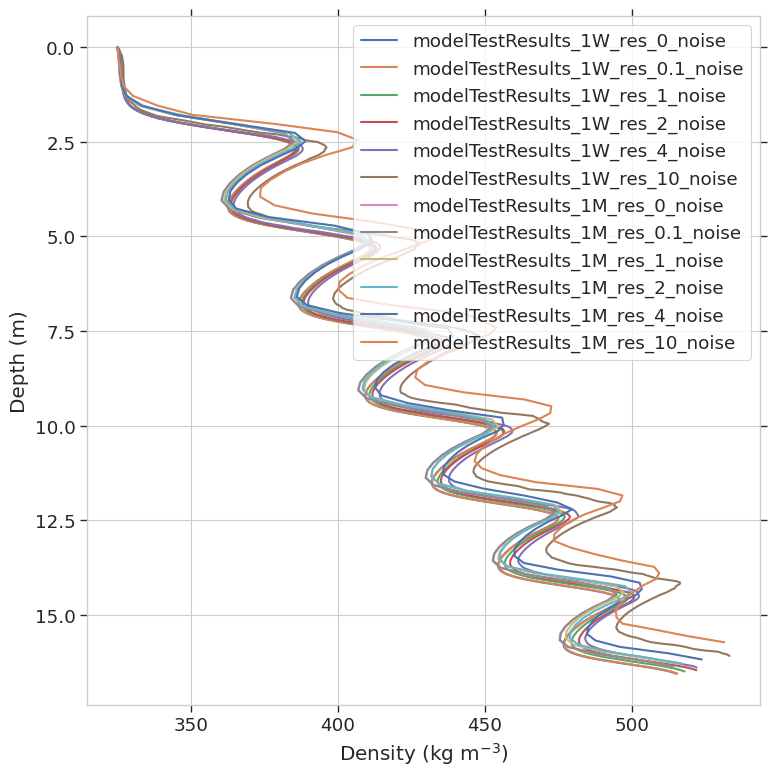

In [32]:
### Plot depth/density
# this is the density profile at the last time

# make dictionary of plot line types that transitions smoothly between things, and differentiates between W and M  

f1,a1=plt.subplots(figsize=(8,8))
for rt in fns:
    a1.plot(rd[rt]['density'][-1,:],rd[rt]['depth'][-1,:],label=rt)
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('Density (kg m$^{-3}$)')
a1.set_ylabel('Depth (m)')



Text(0, 0.5, 'Depth (m)')

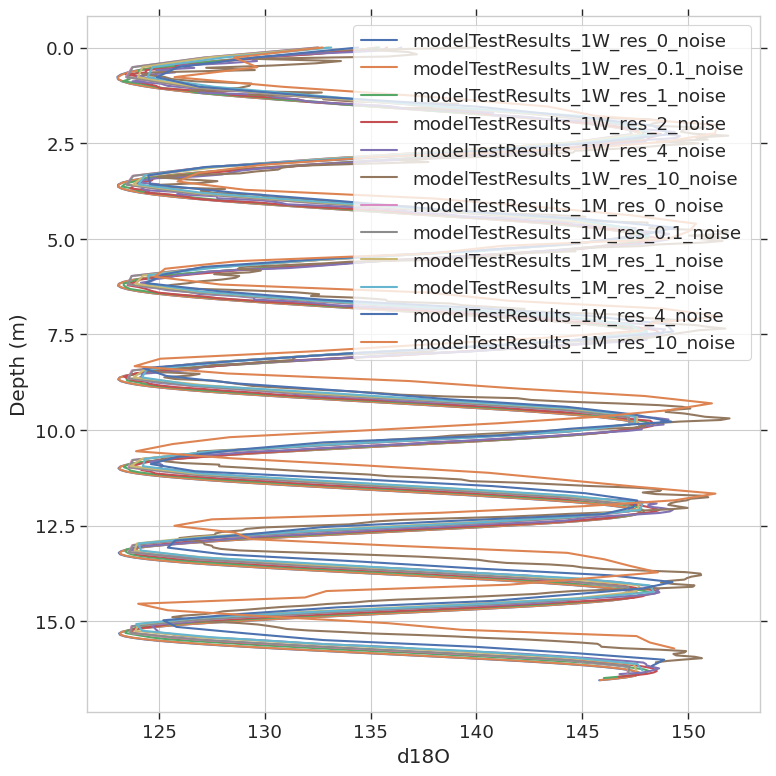

In [33]:
### Plot depth/density
f1,a1=plt.subplots(figsize=(8,8))
for rt in fns:
    a1.plot(rd[rt]['isotopes_d18O'][-1,:],rd[rt]['depth'][-1,:],label=rt)
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('d18O')
a1.set_ylabel('Depth (m)')

Text(0, 0.5, 'Depth (m)')

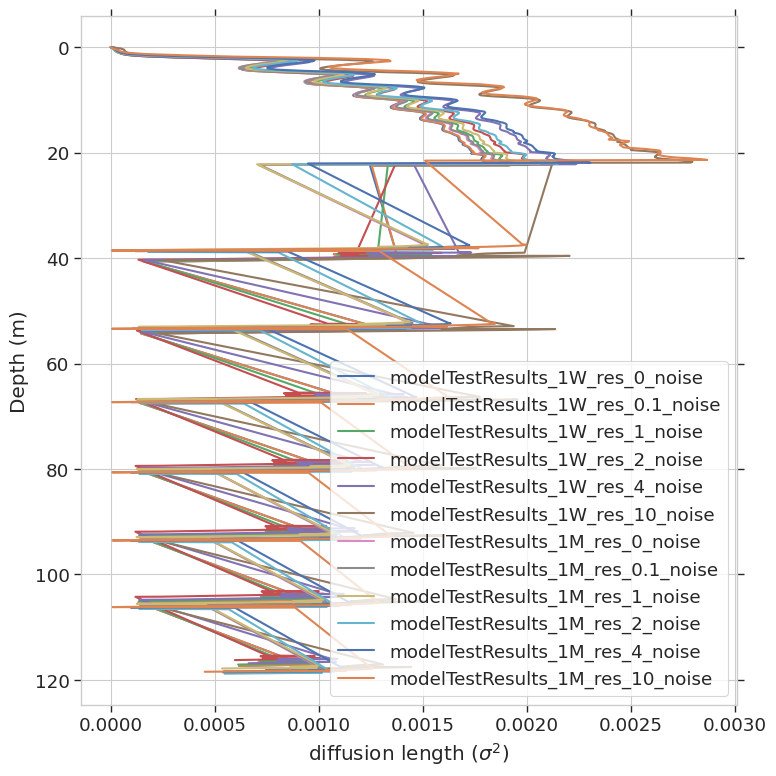

In [25]:
### Plot depth/density
f1,a1=plt.subplots(figsize=(8,8))
for rt in fns:
    a1.plot(rd[rt]['sig2_d18O'][-1,:],rd[rt]['depth'][-1,:],label=rt)
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('diffusion length ($\sigma^{2}$)')
a1.set_ylabel('Depth (m)')